In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = (12, 9)
plt.rcParams["font.family"] = "DejaVu Sans"

from sklearn.metrics import log_loss
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

RANDOM_STATE = 42

In [2]:
PATH = '/Users/nikolaj/Downloads/'

In [3]:
heart_disease = pd.read_csv(PATH + 'heart_disease.csv', index_col='id')

In [4]:
heart_disease.head()

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
id,,,,,,,,,,,,,,
0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect
1,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal
2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect
3,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal
4,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal


In [5]:
sample = pd.read_csv(PATH + 'sample.csv')

In [6]:
heart_disease.head()

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
id,,,,,,,,,,,,,,
0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect
1,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal
2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect
3,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal
4,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal


In [7]:
heart_disease.info()

<class 'pandas.core.frame.DataFrame'>
Index: 920 entries, 0 to 919
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    object 
 2   dataset   920 non-null    object 
 3   cp        920 non-null    object 
 4   trestbps  861 non-null    float64
 5   chol      890 non-null    float64
 6   fbs       830 non-null    object 
 7   restecg   918 non-null    object 
 8   thalch    865 non-null    float64
 9   exang     865 non-null    object 
 10  oldpeak   858 non-null    float64
 11  slope     611 non-null    object 
 12  ca        309 non-null    float64
 13  thal      434 non-null    object 
dtypes: float64(5), int64(1), object(8)
memory usage: 107.8+ KB


How to deal with NAs
trestbps - mean
chol - mean
fbs - unknown
restecg - moda
thalch - mean
exang - unknown
oldpeak - mean
slope - moda
ca - unknown
thal - unknown



In [8]:
for col in ['trestbps', 'chol', 'thalch', 'oldpeak']:
    heart_disease.fillna({col: heart_disease[col].mean()}, inplace=True)

In [9]:
for col in ['thal', 'slope', 'exang', 'restecg', 'fbs' ]:
    heart_disease.fillna({col: 'unknown'}, inplace=True) 

In [10]:
hd_no_ca = heart_disease.drop('ca', axis=1)

In [11]:
scaler = StandardScaler()

In [12]:
def to_dummy(data):
    obj_type_cols = data.select_dtypes(include=['object'])
    X = pd.get_dummies(obj_type_cols, dtype='int')
    # for col in obj_type_cols: 
    #     n = obj_type_cols[col].nunique() #nr of unique variables in a column
    #     for c in X.columns:
    #         if c.startswith(col):
    #             X[c] = X[c]/n
        #find all columns derived from 'col' and 
        #divide values by a number of derived cols (nr of unique variables) 'n'
        # why i chose this method: https://visualstudiomagazine.com/articles/2024/05/15/clustering-mixed-categorical-and-numeric-data.aspx#:~:text=For%20strictly%20numeric%20data%2C%20the,Bayesian%20probability%20or%20categorical%20utility.
    
   
    return pd.concat([data.select_dtypes(exclude=['object']), X], axis=1)
        

In [13]:
X = to_dummy(hd_no_ca)

In [14]:
X.shape

(920, 33)

In [15]:
X.head()

,age,trestbps,chol,thalch,oldpeak,sex_Female,sex_Male,dataset_Cleveland,dataset_Hungary,dataset_Switzerland,...,exang_True,exang_unknown,slope_downsloping,slope_flat,slope_unknown,slope_upsloping,thal_fixed defect,thal_normal,thal_reversable defect,thal_unknown
id,,,,,,,,,,,,,,,,,,,,,
0,63,145.0,233.0,150.0,2.3,0,1,1,0,0,...,0,0,1,0,0,0,1,0,0,0
1,67,160.0,286.0,108.0,1.5,0,1,1,0,0,...,1,0,0,1,0,0,0,1,0,0
2,67,120.0,229.0,129.0,2.6,0,1,1,0,0,...,1,0,0,1,0,0,0,0,1,0
3,37,130.0,250.0,187.0,3.5,0,1,1,0,0,...,0,0,1,0,0,0,0,1,0,0
4,41,130.0,204.0,172.0,1.4,1,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0


In [16]:
X_scaled = scaler.fit_transform(X)

In [17]:
pca = PCA(0.9, random_state=RANDOM_STATE).fit(X_scaled)

In [18]:
pca.explained_variance_ratio_.shape[0]

18

In [19]:
X_scaled_pca = pca.transform(X_scaled)

In [20]:
X_scaled_pca.shape

(920, 18)

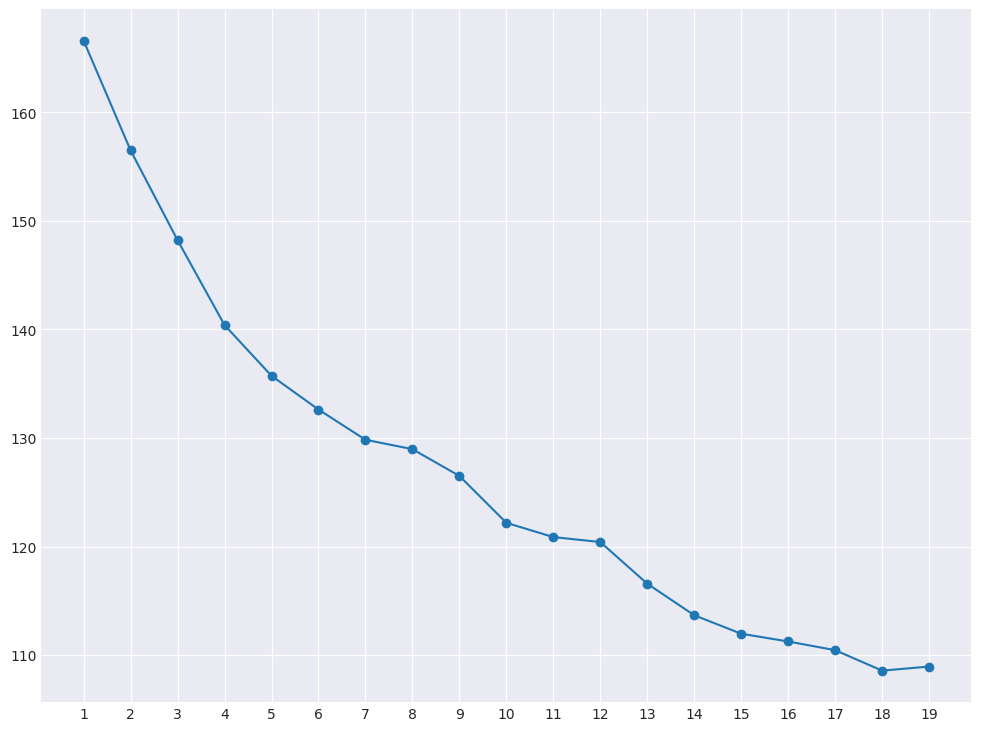

In [21]:
inertia = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    kmeans.fit(X_scaled_pca)
    inertia.append(np.sqrt(kmeans.inertia_))
plt.plot(range(1, len(inertia)+1), inertia, '-o')
plt.xticks(range(1, 20), labels=range(1, 20));

In [22]:
d = {}
for k in range(2, 19):
    i = k - 1
    d[k] = (inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])
d
# k = 10

{2: np.float64(0.8174520584045626),
 3: np.float64(0.9456485111282762),
 4: np.float64(0.5980381838214353),
 5: np.float64(0.6638569412229469),
 6: np.float64(0.8969980442265385),
 7: np.float64(0.31106599835530907),
 8: np.float64(2.846341014473228),
 9: np.float64(1.7519319322987836),
 10: np.float64(0.30418141080623584),
 11: np.float64(0.3481702238627562),
 12: np.float64(8.393862176630469),
 13: np.float64(0.7563962600775933),
 14: np.float64(0.5862573595435152),
 15: np.float64(0.4190193943425347),
 16: np.float64(1.1237552516409308),
 17: np.float64(2.351170627081633),
 18: np.float64(-0.1996207077183497)}

In [23]:
# kmeans = KMeans(n_clusters=10, verbose=1) 24
# kmeans = KMeans(n_clusters=4, verbose=1) 19.9
# kmeans = KMeans(n_clusters=7, verbose=1) 25.17
# kmeans = KMeans(n_clusters=5, verbose=1) 22.83
kmeans = KMeans(n_clusters=4)

In [24]:
kmeans.fit(X_scaled_pca)

KMeans(n_clusters=4)

In [25]:
sample['cluster'] = kmeans.predict(X_scaled_pca[sample.id, :])

In [26]:
sample.tail()

,id,cluster
294,910,3
295,911,3
296,912,3
297,916,3
298,919,3


In [27]:
pca2 = PCA(2, random_state=RANDOM_STATE)
X_scaled_pca2 = pca2.fit_transform(X_scaled)

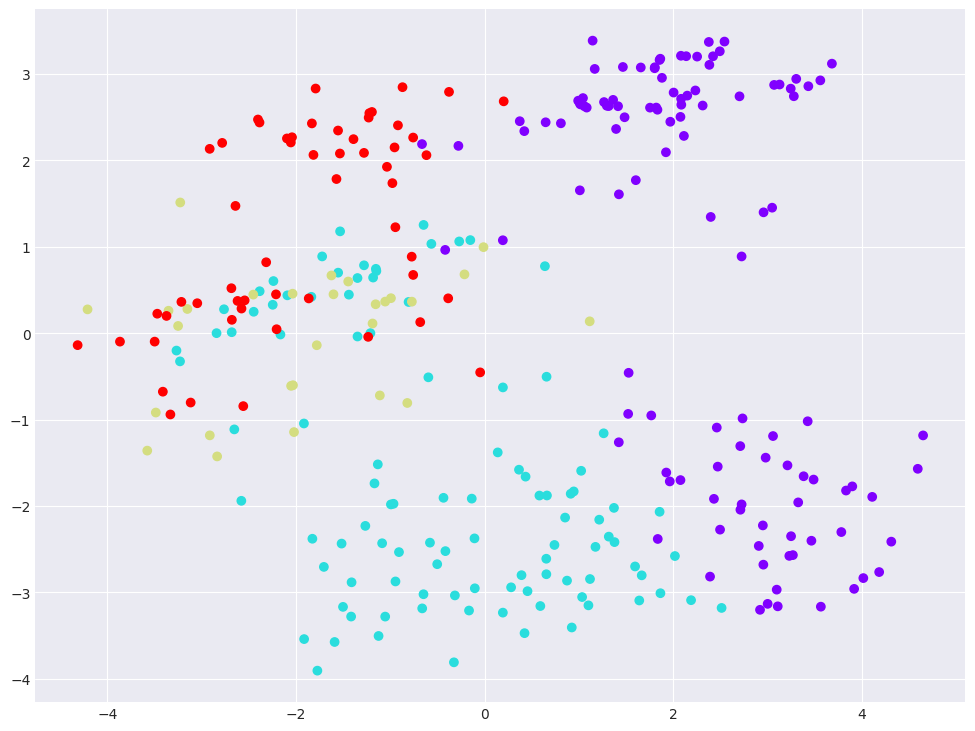

In [32]:
plt.scatter(X_scaled_pca2[sample.id, 0], X_scaled_pca2[sample.id, 1], c=sample.cluster, cmap='rainbow')

In [29]:
sample.to_csv('submission.csv', index=False)

In [31]:
X_scaled

array([[ 1.00738556,  0.69804099,  0.31102075, ..., -0.5203059 ,
        -0.51355259, -1.05821343],
       [ 1.43203377,  1.51176059,  0.79771293, ...,  1.92194629,
        -0.51355259, -1.05821343],
       [ 1.43203377, -0.65815834,  0.27428927, ..., -0.5203059 ,
         1.94722024, -1.05821343],
       ...,
       [ 0.15808914, -0.54966239,  0.21919204, ..., -0.5203059 ,
        -0.51355259, -1.05821343],
       [ 0.4765753 ,  0.        ,  1.70681718, ..., -0.5203059 ,
        -0.51355259,  0.94498895],
       [ 0.90122351, -0.65815834,  0.50386105, ..., -0.5203059 ,
        -0.51355259,  0.94498895]], shape=(920, 33))

In [ ]:
# kmeans = KMeans(n_clusters=10, verbose=1) 24
# kmeans = KMeans(n_clusters=4, verbose=1) 19.9
# kmeans = KMeans(n_clusters=7, verbose=1) 25.17
# kmeans = KMeans(n_clusters=5, verbose=1) 22.83
# k = 4 and simple dummies without division 16.97

In [35]:
sum(pca.explained_variance_ratio_[:3])

np.float64(0.3506594884631587)